# Plot facereader points

In [1]:
from os.path import join, isfile
from os import listdir
from PIL import Image
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot
from pylab import figure
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import csv
import itertools
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import json
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, confusion_matrix
import jsonlines

In [3]:
import classifiers_general

In [4]:
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien"
syn_list = ['ADNP', 'ANKRD11','CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'WAC', 'YY1', 'KDVS']

In [5]:
LEFT = [0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341]
RIGHT = [9, 10, 11, 12, 13, 14, 15, 16, 17, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 157, 158, 168, 173, 174, 190, 191, 205, 210, 213, 217, 262, 263, 269, 278, 281, 282, 284, 288, 292, 294, 295, 296, 297, 298, 299, 302, 304, 305, 306, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509]

In [6]:
def get_pairs(length):
    pairs = []
    combs = [comb for comb in itertools.combinations([*range(0, length)], 2)]
    for comb in combs:
        a = comb[0]
        b = comb[1]  
        pairs.append([a, b])
    
    return pairs

def get_distances(keypoints):
    feats  = []
    combs = [comb for comb in itertools.combinations([*range(0, len(keypoints))], 2)]
    for comb in combs:
        a = comb[0]
        b = comb[1]
        feats.append(distance.euclidean(keypoints[a], keypoints[b]))
    
    return feats

## From landmark to all distances for syndromic files - run only once

## From landmark to all distances for control files - run only once

# Get most important distance for RF classifcation

In [7]:
def get_important_features(syn_name, data_dir, nr_feats): 
    method = "facereader-landmarks-distances"
    syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
    ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
    data_fr, labels_fr = classifiers_general.read_rep(syn_name, syn_csv, ID_csv, data_dir)

    data, labels  = [], []
    for index, data_i in enumerate(data_fr):
        if not all(v == 0 for v in data_i):
            data.append(data_i) 
            labels.append(labels_fr[index])

    forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
    forest.fit(data, labels)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    important_indices = indices[0:nr_feats] 

    data2 = []
    for row in data:
        data2.append(np.array(row)[important_indices])                                
    data = data2
                
    return np.array(data), np.array(labels), important_indices

def get_keypoints_from_indices(indices):
    combs = [comb for comb in itertools.combinations([*range(0, 510)], 2)]
    keypoints = []
    for index, comb in enumerate(combs):
        if index in indices:              
            a = comb[0]
            b = comb[1]
            keypoints.append([a, b])
    return keypoints

In [8]:
def load_landmarks(patient, GENERAL_DIR):
    face_x, face_y, face_z = [], [], []    
    file = GENERAL_DIR + "\\features_facereader_landmarks_patient_groups.csv"

    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if patient in row[0]:
                indexed_keypoints = []
                i = 1
                while i < len(row[1:]):
                    indexed_keypoints.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    face_x.append(float(row[i]))
                    face_y.append(float(row[i+1]))
                    face_z.append(float(row[i+2]))
                    i+=3    
                break  
    return np.array(face_x), np.array(face_y), np.array(face_z), indexed_keypoints

In [9]:
def get_patient_keypoints(important_keypoints, indexed_keypoints):
    keypoints3D = []       
    for [a, b] in important_keypoints:      
        keypoints3D.append([indexed_keypoints[a], indexed_keypoints[b]])      
    return keypoints3D

# Split faces (before left/right indices were known)

### Save distance data in seperate right and left csv files - patients (only once)

### Save distance data in seperate right and left csv files - controls (only once)

In [10]:
def load_data(syn, side, GENERAL_DIR):
    # files with representations
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_distances_patient_groups_{}.csv".format(side)
    ID_csv = GENERAL_DIR+ "\\features_facereader_landmarks_distances_all_controls_{}.csv".format(side)
    
    # open directories
    syn_dir = GENERAL_DIR+"\\{}\\{}-patients".format(syn, syn)
    ID_dir = GENERAL_DIR+ "\\{}\\{}-selected-ID-controls".format(syn, syn)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data, labels, data_syn, data_ID = [], [], [], []
    
    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn: 
                rep = list(map(float, row[1:]))
                data_syn.append(rep)
                    
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = list(map(float, row[1:]))
                data_ID.append(rep)
    
    for index, (syn_item, ID_item) in enumerate(zip(data_syn, data_ID)):
        if len(syn_item) == 36315 and len(ID_item) == 36315: # hardcoded for now
            data.append(np.array(syn_item))
            labels.append(1)
            data.append(np.array(ID_item))
            labels.append(0)

    return np.array(data), np.array(labels)

### Train RF and save scores - get 10 most important features 

In [47]:
results_file = open("results_landmarks/results_landmarks_left_right.txt", "w")
importance_indices_list = []

for syn in tqdm(syn_list): 
    indices_left, indices_right = [], []

    for side in ["left", "right"]:
        data, labels = load_data(syn, side, GENERAL_DIR)
        data = Normalizer().fit_transform(data)

        results_file.write("Syndrome {} with {} patients and {} controls - {}\n".format(syn, labels.tolist().count(1), labels.tolist().count(0), side))

        ### RANDOM FOREST SCORE ###
        data = Normalizer().fit_transform(data)
        all_y, all_probs, all_preds = [], [], [] 
        loo = LeaveOneOut()

        for train, test in loo.split(data):
            all_y.append(labels[test])
            model = RandomForestClassifier(n_estimators=10)
            model = model.fit(data[train], labels[train])
            all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
            all_preds.append(model.predict(data[test].reshape(1, -1)))

        # based on all predictions make aroc curve and confusion matrix
        aroc = roc_auc_score(all_y, all_probs)
        tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
        spec = tn / (tn+fp)  
        sens = tp / (tp+fn)
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n\n".format(aroc, spec, sens))
        
#         ### SAVE MOST IMPORTANT INDICES LEFT/RIGHT ### - only done once
#         forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
#         forest.fit(data, labels)
#         importances = forest.feature_importances_
#         std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
#         indices = np.argsort(importances)[::-1]

#         nr_feat = 10
#         important_indices = indices[0:nr_feat] # aantal features
#         print("{} features have an importance of {:.4f}".format(nr_feat, sum(importances[important_indices])))

#         if side == "left":
#             indices_left = important_indices
#             importance_left = sum(importances[important_indices])
#         else:
#             indices_right = important_indices
#             importance_right = sum(importances[important_indices])
    
#     importance_indices_list.append({syn: {"left": indices_left.tolist(), "left_importance": importance_left, "right": indices_right.tolist(), "right_importance": importance_right}})
results_file.close()

100%|█████████████████████████████████████████| 11/11 [18:25<00:00, 100.46s/it]


### Save the most important features for the split faces

### Find 11 random sample images

In [34]:
## find 11 random pictures 
sample_data = {}
file = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"

# Find random image of syndrome and retrieve keypoints 
with open(file, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for syn in syn_list:
            
            if syn in row[0] and len(row[1:]) == 1530:
                landmarks_left, landmarks_right = [], []
                i = 1
                count = 0

                while i < len(row[1:]):
                    if count in LEFT:
                        landmarks_left.append((float(row[i]), float(row[i+1]), float(row[i+2])))
                    if count in RIGHT:
                        landmarks_right.append((float(row[i]), float(row[i+1]), float(row[i+2])))

                    count += 1
                    i+=3   
                
                sample_data[syn] = {"image": row[0], "landmarks_left": landmarks_left, "landmarks_right": landmarks_right}               
                break

In [36]:
print(sample_data.keys())

dict_keys(['ANKRD11', 'ADNP', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'WAC', 'YY1', 'KDVS'])


### Read in the most important indices from json

In [13]:
new_filename = "results_landmarks/most_important_features.jsonl"
results = {}
with jsonlines.open(new_filename) as reader:
    for index, line in enumerate(reader):
        results[syn_list[index]] = line[syn_list[index]]

In [26]:
print(results['CDK13'])

{'left': [13015, 18588, 18814, 33902, 25913, 19813, 19873, 1207, 2544, 1431], 'left_importance': 0.6999750085800626, 'right': [18125, 13068, 23713, 18690, 21625, 28114, 16712, 23968, 10247, 32028], 'right_importance': 0.6595310608392326}


<IPython.core.display.Javascript object>


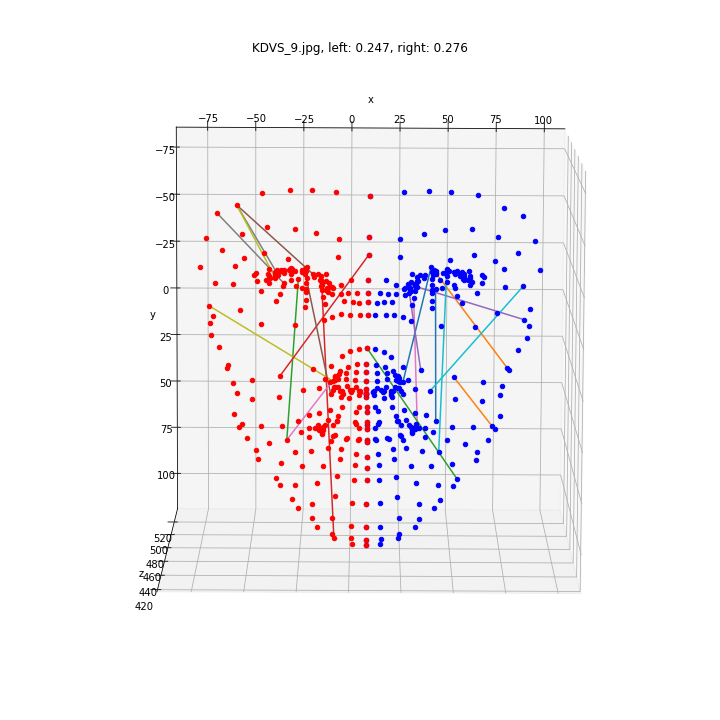

In [45]:
%matplotlib notebook

syn = syn_list[10]

#for syn in results.keys():
result = results[syn]
indices_left = result['left']
left_importance = result['left_importance']
indices_right = result['right']
right_importance = result['right_importance']

sample = sample_data[syn]
image = sample['image']
landmarks_left = sample['landmarks_left']
landmarks_right = sample['landmarks_right']

fig = figure(figsize=(10,10))
ax = Axes3D(fig)

# plot the left and right side
for [x, y, z] in landmarks_left:
    ax.scatter(x, y, z, color='b') 
for [x, y, z] in landmarks_right:
    ax.scatter(x, y, z, color='r') 

# get keypoint pairs of indices most important features
pairs = get_pairs(len(LEFT))

# plot the most important features (pairwise distance)
for index, [a,b] in enumerate(pairs):
    if index in indices_left:
        [x, y, z] = landmarks_left[a]
        [x2, y2, z2] = landmarks_left[b]
        ax.plot((x, x2), (y, y2), (z, z2))

    if index in indices_right:
        [x, y, z] = landmarks_right[a]
        [x2, y2, z2] = landmarks_right[b]
        ax.plot((x, x2), (y, y2), (z, z2))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
title = "{}, left: {:.3f}, right: {:.3f}".format(image, left_importance, right_importance)
ax.set_title(title)
pyplot.show()

In [16]:
### code was for whole face ###
# syn_name = 'KDVS'
# patient = 'KDVS_1.jpg'
# GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien"

# x, y, z, indexed_keypoints = fr_plot(patient, GENERAL_DIR)

# data_dir = GENERAL_DIR + "\\{}".format(syn_name) 
# nr_feats = 10

# _, _, indices = get_important_features(syn_name, data_dir)
# important_keypoints = get_keypoints_from_indices(indices)
# keypoints_3d = get_patient_keypoints(important_keypoints, indexed_keypoints)